The intent of this algorithm is to model the dynamic between institutional factors that contribute to federal grant awards to prospective students, producing a fair and accurate recommendation for the grant award amount. Machine learning in situations like this can reduce implicit or latent biases that prevent financial access to higher education for all individuals. To prevent algorithmic discrimination, the only dimensions required for modeling for grant awards are the location of the school, the school type, whether the school is in the prospective student’s home state, and the tuition amount. all other factors have the potential to introduce biases into the model and are not relevant for producing a performant model.

The availability of data representing grant awards at the individual student level, and the percent of tuition covered by the grant are either non-existent or unknown at the time of designing this algorithm. However, the combination of multiple public datasets can allow us to approximate this student-level data.

The features of the model, or independent variables, reflect qualities about the educational institution, and the dependent variable is the percentage amount of tuition that was covered by a federal grant.

#### Training data:
- [Sources of Grant Aid for Full-Time Undergraduates by Sector, 2011-12 - Pell Grant data](https://trends.collegeboard.org/content/sources-grant-aid-full-time-undergraduates-sector-2011-12)
- [Federal Student Aid: Title IV Program Volume Reports - grants per institution](https://studentaid.ed.gov/sa/about/data-center/student/title-iv)
- [College Scorecard - tuition data](https://catalog.data.gov/dataset/college-scorecard) (Accessing this data requires an API key for data.gov, which is granted here: [https://api.data.gov/signup/](https://api.data.gov/signup/))

In [2]:
%config InlineBackend.figure_format = 'retina'

import glob
import json
import os
import numpy as np
import pandas as pd
import requests

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn_transformers.preprocessing import FeatureSelector
from sklearn_transformers.preprocessing import MultiColumnLabelEncoder
from sklearn_transformers.regression import RegressorWithNoise
from helpers import regression_report

### Download data:

To model the scenario outlined above, the data required is an anonymized individual-level federal grant award dataset (where each row represents one person’s school, the school’s tuition, and the percent of the tuition the grant amount covered). Unfortunately, the government does readily provide such a dataset, however, these features can be assembled with other existing datasets: the Pell Grant data for full-time undergraduate students which provides the maximum amount awarded per student, the Federal Student Aid's Title IV program which outlines the total amount of grants per educational institution, and lastly the educational institution's tuition provided by College Scorecard.

The first dataset (Sources of Grant Aid for Full-Time Undergraduates by Sector, 2011-12), will provide the maximum Pell Grant amounts awarded per year. The maximum amount award will later be used to determine the percent awarded.

In [8]:
pell_grat_filename = 'data/pell_grant.xlsx'
pell_grant_url = 'http://research.collegeboard.org/sites/default/files/sa-2018-figure-21a.xlsx'

response = requests.get(pell_grant_url)
with open(pell_grat_filename, 'wb') as out_file:
    out_file.write(response.content)

In [17]:
def parse_pell_grant_data_start_year(x):
    s = int(x[:2])
    if s >= 77:
        return str(1900 + s)
    else:
        return str(2000 + s)

pell_grant_data = pd.read_excel(
    pell_grat_filename,
    header=1,
    usecols=[i for i in range(3)],
)
pell_grant_data = pell_grant_data[:41]
pell_grant_data['start_year'] = pell_grant_data['Academic Year'].apply(parse_pell_grant_data_start_year)
pell_grant_data.columns = [col.strip().lower().replace(' ', '_') for col in pell_grant_data.columns]
print(pell_grant_data.shape)

(41, 4)


The second dataset is the Federal Student Aid Title IV Volume reports that detail grand disbursements per institution per year (from https://studentaid.ed.gov/sa/about/data-center/student/title-iv). The Q4 data has the complete data for the given year.

In [33]:
base_url = 'https://studentaid.gov/sites/default/files/'
student_loans_data_urls = []

for year in range(6, 18):
    this_year = f'{year}'.zfill(2)
    next_year = f'{year + 1}'.zfill(2)
    if 13 <= year:
        url = f'{base_url}fsawg/datacenter/library/'
    else:
        url = base_url        
    student_loans_data_urls.append(f'{url}Q4{this_year}{next_year}AY.xls')  

for url in student_loans_data_urls:
    print(url)
    filename = os.path.basename(url)
    response = requests.get(url)
    with open(filename, 'wb') as out_file:
        out_file.write(response.content)

https://studentaid.gov/sites/default/files/Q40607AY.xls
https://studentaid.gov/sites/default/files/Q40708AY.xls
https://studentaid.gov/sites/default/files/Q40809AY.xls
https://studentaid.gov/sites/default/files/Q40910AY.xls
https://studentaid.gov/sites/default/files/Q41011AY.xls
https://studentaid.gov/sites/default/files/Q41112AY.xls
https://studentaid.gov/sites/default/files/Q41213AY.xls
https://studentaid.gov/sites/default/files/fsawg/datacenter/library/Q41314AY.xls
https://studentaid.gov/sites/default/files/fsawg/datacenter/library/Q41415AY.xls
https://studentaid.gov/sites/default/files/fsawg/datacenter/library/Q41516AY.xls
https://studentaid.gov/sites/default/files/fsawg/datacenter/library/Q41617AY.xls
https://studentaid.gov/sites/default/files/fsawg/datacenter/library/Q41718AY.xls


The grants data is in semi-regularly formatted excel spreadsheets, the code below extracts the relevant data from the sheets, and formats the data for use in a dataframe.

In [61]:
grant_fileinfo = [
    {'filepath': 'data/Q40607AY.xls', 'sheet_name': 'Q4 0607 YTD', 'header_col': 3},
    {'filepath': 'data/Q40708AY.xls', 'sheet_name': 'Q4 0708 YTD', 'header_col': 3},
    {'filepath': 'data/Q40809AY.xls', 'sheet_name': 'Q4 0809 YTD', 'header_col': 3},
    {'filepath': 'data/Q40910AY.xls', 'sheet_name': 'Q4 0910 YTD', 'header_col': 4},
    {'filepath': 'data/Q41011AY.xls', 'sheet_name': 'Q4 1011 YTD', 'header_col': 4},
    {'filepath': 'data/Q41112AY.xls', 'sheet_name': 'Q4 1112 YTD', 'header_col': 4},
    {'filepath': 'data/Q41213AY.xls', 'sheet_name': 'Q4 1213 YTD', 'header_col': 4},
    {'filepath': 'data/Q41314AY.xls', 'sheet_name': 'Award Year Summary', 'header_col': 4},
    {'filepath': 'data/Q41415AY.xls', 'sheet_name': 'Award Year Summary', 'header_col': 4},
    {'filepath': 'data/Q41516AY.xls', 'sheet_name': 'Award Year Summary', 'header_col': 4},
    {'filepath': 'data/Q41617AY.xls', 'sheet_name': 'Award Year Summary', 'header_col': 4},
    {'filepath': 'data/Q41718AY.xls', 'sheet_name': 'Award Year Summary', 'header_col': 4},
]

In [84]:
grant_dfs = []

for info in grant_fileinfo:
    filepath = info['filepath']
    sheet_name = info['sheet_name']
    header_col = info['header_col']
    print(filepath)
    temp_df = pd.read_excel(filepath, sheetname=sheet_name, header=[header_col, header_col+1])
    col_index = [True if col.startswith('Unnamed') or col == 'FEDERAL PELL GRANT PROGRAM' else False
                 for col in temp_df.columns.get_level_values(0)
                ]
    temp_df = temp_df.iloc[:, col_index]
    temp_df.columns = temp_df.columns.droplevel()
    label = filepath.split('/')[-1][:-4]
    temp_df['spreadsheet'] = label
    temp_df['academic_year'] = f'20{label[2:4]}'
    temp_df.columns = map(str.lower, temp_df.columns)
    temp_df.index.name = 'ope id'
    temp_df = temp_df.rename(columns={
        'sum of recipients': 'pell grant ytd recipients',
        'ytd recipients': 'pell grant ytd recipients',
        'sum of disbursements':  'pell grant ytd disbursements',
        'ytd disbursements': 'pell grant ytd disbursements',
    })
    temp_df = temp_df.reset_index()
    temp_df['ope id'] = temp_df['ope id'].apply(lambda x: str(x).zfill(8))
    grant_dfs.append(temp_df)


grants_df = pd.concat(grant_dfs)
print(grants_df.shape)
grants_df.sample(5)

data/Q40607AY.xls
data/Q40708AY.xls
data/Q40809AY.xls
data/Q40910AY.xls
data/Q41011AY.xls
data/Q41112AY.xls
data/Q41213AY.xls
data/Q41314AY.xls
data/Q41415AY.xls
data/Q41516AY.xls
data/Q41617AY.xls
data/Q41718AY.xls
(65518, 10)


,academic_year,ope id,pell grant ytd disbursements,pell grant ytd recipients,school,school type,spreadsheet,state,ytd recipients,zip code
3115,2017,02138300,309749,68,PALO ALTO UNIVERSITY,Private-Nonprofit,Q41718AY,CA,NaN,943041337.0
1674,2015,00364500,3.28155e+06,819,TEXAS WESLEYAN UNIVERSITY,Private-Nonprofit,Q41516AY,TX,NaN,761051536.0
1040,2016,00265300,4.96149e+06,1261,NEW MEXICO HIGHLANDS UNIVERSITY,Public,Q41617AY,NM,NaN,877014436.0
5275,2008,3965500.0,162784,53,HAIR EXPRESSIONS ACADEMY,PROPRIETARY,Q40809AY,MD,NaN,208521729.0
2345,2009,00208700,317686,74,NER ISRAEL RABBINICAL COLLEGE ...,Private-Nonprofit,Q40910AY,MD,NaN,212081198.0


Lastly, we need to know the tutition cost for each educational institution listed in the `grant_amounts` dataset. This data is provided by [College Scorecard on data.gov](https://catalog.data.gov/dataset/college-scorecard). However, it requires an API key ([sign up here](https://api.data.gov/signup/)) to programmatically download the data. Also, the API is rate limited, so this step can take a while. This cell is designed to run multiple times until the full data is collected.

In [44]:
url = 'https://api.data.gov/ed/collegescorecard/v1/schools'
API_KEY = #'<INSERT YOUR DATA.GOV API KEY HERE>'
params = {
    'api_key': API_KEY,
    '_per_page': 100
}
ids = set(grants_df['ope id'].values) - {fp.split('/')[-1][:8] for fp in glob.glob('data/*.json')}

for ope_id in ids:
    params = {'ope8_id': ope_id}
    local_filename = f'{ope_id}_tuition_data.json'
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        with open(local_filename, 'wb') as out_file:
            out_file.write(response.content)
    if response.status_code != 200:
        print(f'error: {response.url}, {response.status_code}, {json.dumps(response.text)}')
    if int(response.headers['X-RateLimit-Remaining']) == 0:
        print('stopping, over rate limit')
        break

    print('X-RateLimit-Remaining:', int(data.response.headers['X-RateLimit-Remaining']))

In [86]:
filepaths = glob.glob('data/*_tuition_data.json')
school_data = []
for fp in filepaths:
    with open(fp, 'r') as infile:
        d = json.load(infile)
    if len(d['results']) == 0:
        continue
    for k, v in d['results'][0].items():
        try:
            row = {
                'ope8_id': fp.split('/')[-1][:8],
                'year': int(k),
                'out_of_state_tuition': v['cost']['tuition']['out_of_state'],
                'in_state_tuition': v['cost']['tuition']['in_state'],
            }
            school_data.append(row)
        except:
            pass

tuition_df = pd.DataFrame(school_data, columns=['ope8_id', 'year', 'out_of_state_tuition', 'in_state_tuition'])
tuition_df = tuition_df.sort_values(by=['ope8_id', 'year']).reset_index(drop=True)
print(tuition_df.shape)
print(len(tuition_df.ope8_id.unique()))
tuition_df.sample(5)

(91819, 4)
4993


,ope8_id,year,out_of_state_tuition,in_state_tuition
84423,03513400,2006,2350.0,2350.0
12439,00193800,2015,3624.0,3168.0
46070,00697700,1996,NaN,NaN
13936,00204100,2005,10830.0,4740.0
76213,02587500,2015,5820.0,5820.0


This step combines the three datasets into a single dataframe.

In [53]:
grants_df = grants_df.merge(
    pell_grant_data[['start_year', 'maximum_pell_grant']],
    left_on=['academic_year'],
    right_on=['start_year'],
)
grants_df['academic_year'] = grants_df['academic_year'].astype('int64')

_df = grants_df.merge(
    tuition_df, 
    how='left',
    left_on=['ope id', 'academic_year'],
    right_on=['ope8_id', 'year'],
)

print(_df.shape)
_df.sample(5)

(65518, 15)


,ope id,school,state,zip code,school type,pell grant ytd recipients,pell grant ytd disbursements,spreadsheet,academic_year,start_year,maximum_pell_grant,ope8_id,year,out_of_state_tuition,in_state_tuition
33842,00116300,CHAFFEY COMMUNITY COLLEGE,CA,917379400,PUBLIC,8178,24161737,Q41213AY,2012,2012,5930,00116300,2012.0,6169.0,1153.0
48108,02606300,PAUL MITCHELL THE SCHOOL WICHITA,KS,672261321,Proprietary,136,515309,Q41415AY,2014,2014,5890,02606300,2014.0,NaN,NaN
28830,00280600,ROCHESTER INSTITUTE OF TECHNOLOGY,NY,146235608,Private-Nonprofit,4378,17252884,Q41112AY,2011,2011,6010,00280600,2011.0,32037.0,32037.0
5909,00161400,KAUAI COMMUNITY COLLEGE,HI,967669591,PUBLIC,173,397713,Q40708AY,2007,2007,5060,00161400,2007.0,6184.0,1552.0
28862,00285300,SUNY MARITIME COLLEGE,NY,104654198,Public,449,1799213,Q41112AY,2011,2011,6010,00285300,2011.0,15507.0,6457.0


### Preprocess:

In order to transform the raw data into a state where we can properly model the data, some preprocessing must occur. There are three predominant transformations: `calculate_average_amount()`, `convert_region()`, and determining the `grant_coverage_percent` based on in-state or out-of-state students, as well as the cleanup and standarization of some columns.

In [92]:
_df = _df.rename(columns={'school type': 'school_type'})
_df = _df[[
    'school_type',
    'pell grant ytd disbursements',
    'pell grant ytd recipients',
    'state',
    'maximum_pell_grant',
    'out_of_state_tuition',
    'in_state_tuition',
]]
_df = _df[~_df['pell grant ytd recipients'].isin(['-'])]

def convert_to_numeric(x):
    try:
        return pd.to_numeric(x)
    except:
        return np.nan

_df['pell grant ytd disbursements'] = _df['pell grant ytd disbursements'].apply(convert_to_numeric)
_df['pell grant ytd recipients'] = _df['pell grant ytd recipients'].apply(convert_to_numeric)
_df['school_type'] = _df['school_type'].str.lower()

The first transformation, `calculate_average_amount()`, calculates the average amount of grant disbursements. To do so, it divides the total grant amount per institution per year by the total number of grant recipients per institution per year.

In [93]:
def calculate_average_amount(row):
    if row['pell grant ytd recipients'] > 0:
        return row['pell grant ytd disbursements'] / row['pell grant ytd recipients']
    else:
        return 0.0

_df['avg_amount'] = _df.apply(calculate_average_amount, axis=1)

The second transformation, `convert_region()`, determines the educational institution's geographical region by the state it's located in. This reduces feature complexity and allows for broader geographic patterns to be a identified within the model.

In [94]:
state_regions = {
    'northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NY', 'NJ' , 'PA'],
    'midwest': ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
    'south': ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'DC', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX', 'PR', 'AS', 'VI'],
    'west': ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA', 'GU', 'FM', 'MH', 'MP', 'PW'],
}

def convert_region(state_abbr):
    for region, states in state_regions.items():
        if state_abbr in states:
            return region
    return


_df['region'] = _df['state'].apply(convert_region)
_df = _df.dropna(subset=['region'])

The following preprocessing step splits the grant awards by in-state and out-of-state schools.

In [95]:
df_1 = _df.copy()[_df['maximum_pell_grant'] >= _df['out_of_state_tuition']]
df_1['in_state'] = False
df_1['grant_coverage_percent'] = df_1['avg_amount'] / df_1['out_of_state_tuition']

df_2 = _df.copy()[_df['maximum_pell_grant'] >= _df['in_state_tuition']]
df_2['in_state'] = True
df_2['grant_coverage_percent'] = df_2['avg_amount'] / df_2['in_state_tuition']

df = pd.concat([
    df_1[['school_type', 'region', 'in_state', 'grant_coverage_percent']],
    df_2[['school_type', 'region', 'in_state', 'grant_coverage_percent']]
])

Lastly, the final transformation required in the preprocessing step is determining the `grant_coverage_percent`.

In [96]:
df = df[df['grant_coverage_percent'] >= 1]
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['grant_coverage_percent'])

print(df.shape)
df.sample(5)

(4473, 4)


,school_type,region,in_state,grant_coverage_percent
38802,public,west,True,2.912159
18076,public,midwest,True,1.127620
19010,public,midwest,True,1.322399
55312,public,south,True,1.018625
33485,public,west,True,2.912652


## Model:

In [97]:
feature_columns = ['school_type', 'region', 'in_state']
target_column = 'grant_coverage_percent'

x = df.copy()[feature_columns]
y = df.copy()[target_column]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)

print(len(x_train), len(x_test))

3578 895


In [98]:
model = Pipeline([
    ('feature_column_encoder', MultiColumnLabelEncoder(columns=feature_columns)),
    ('estimator', RegressorWithNoise(
        RandomForestRegressor(
            n_estimators=1000,
            max_features='sqrt',
            max_depth=30,
            random_state=1337,
        )
    ))
])
model.fit(x_train, y_train)

Pipeline(steps=[('feature_column_encoder', <sklearn_transformers.preprocessing.MultiColumnLabelEncoder object at 0x7fa43c4a5ba8>), ('estimator', RegressorWithNoise(regressor=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='sqrt', max_leaf_nodes=None,
           mi...ators=1000, n_jobs=1, oob_score=False, random_state=1337,
           verbose=0, warm_start=False)))])

Accuracy:                     68.46007
MSE                           0.584932
RMSE                          0.764809
RMSLE                         0.228085
MAE                           0.502928
R2                            0.238108
Adj R2                        0.235607
Median                        1.496856
Avg absolute error (degrees)  0.502928

----------------------------------------
Feature Importances:
school_type=proprietary       0.897887
school_type=public            0.058283
school_type=private-nonprofit 0.043830


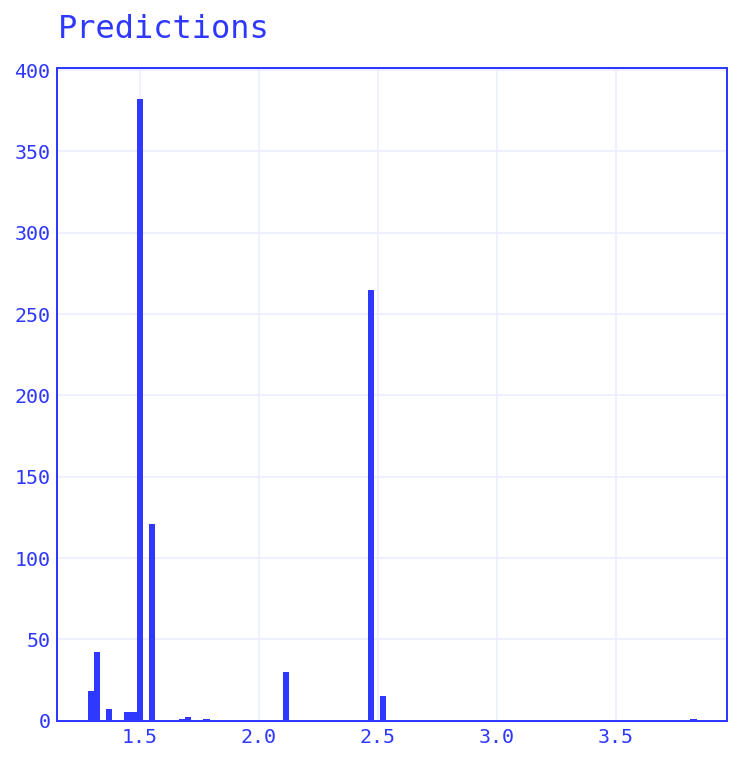

array([ 1.68771123,  1.46041356,  1.68771123,  1.28954312,  1.68771123])

In [100]:
regression_report.evaluate(model, x_test, y_test, encoder_step_label='feature_column_encoder')
display(model.predict(x_test.sample(5)))